## Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей.   
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека.   
В вашем распоряжении набор фотографий людей с указанием возраста.


# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.info())
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Входные данные представляют собой:  
- файл, в котором перечислены наименования файлов картинок и соответствующее этой картинке возраст человека, изображенного на ней;  
- отдельный подкаталог с картинками, которые перечислены в первом файле.  

Размер выборки составляет 7591 запасей (столько же файлов в подкаталоге).

***

### Вывод 15-ти фотографий на экран.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [7]:
# размер одной фотографии

train_gen_flow.image_shape

(224, 224, 3)

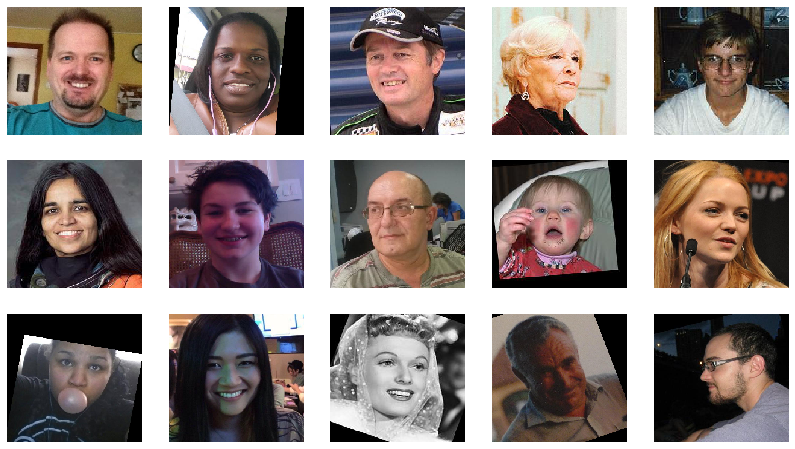

In [8]:
# 15 первых фотографий

fig, ax = plt.subplots(3, 5, figsize=(14, 8))
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(train_gen_flow[0][0][i*5+j], aspect="auto")
        ax[i, j].axis('off')

plt.show()

## Распределение восраста в выборке

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


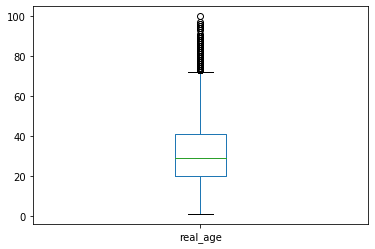

In [9]:
print(labels.describe())
labels['real_age'].plot(kind='box');

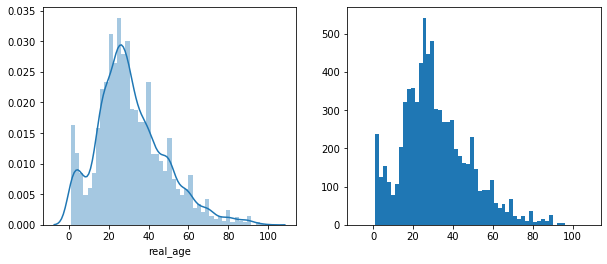

In [10]:
# гистограмма (количество возрастов) и kde

f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
sns.distplot(labels['real_age'], ax=axes[0])
axes[1] = plt.hist(labels['real_age'], bins=50)
plt.show()

In [11]:
# всего уникальных значений возраста

print('Всего возрастов:', len(labels['real_age'].unique()))
labels['real_age'].unique()

Всего возрастов: 97


array([  4,  18,  80,  50,  17,  27,  24,  43,  26,  39,  51,   2,   1,
         6,   5,  40,  16,  29,  35,  25,  30,  65,  13,  28,  31,  10,
        34,  15,   8,  20,  19,  42,  23,  58,  44,   7,  21,  14,  48,
        45,  37,  22,  59,  53,   9,  41,  32,  60,  38,  54,  49,  36,
        11,  70,  52,  33,  72,  47,  46,  55,  63,  12,  56,   3,  68,
        64,  67,  62,  57,  75,  61,  69,  90,  85,  88,  73,  71,  83,
        84,  87,  66,  82,  86,  77, 100,  79,  78,  76,  94,  89,  74,
        97,  93,  81,  95,  96,  91])

In [12]:
labels['real_age'].value_counts().to_frame('age_count').T

,30,25,27,26,28,23,24,18,16,19,...,88,86,83,81,95,96,100,93,91,97
age_count,317,315,229,226,217,213,211,193,193,180,...,3,3,3,3,2,2,1,1,1,1


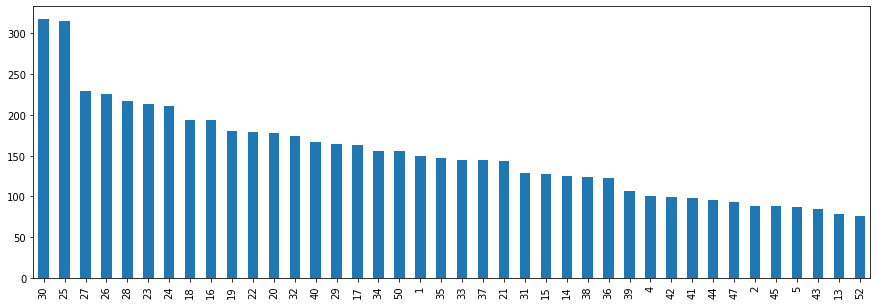

In [13]:
# 40 самых популярных возрастов

labels['real_age'].value_counts()[:40].plot.bar(figsize=(15, 5));

Как видно из данных и диаграмм, основное количество людей имеют возраста от 14 до 48 лет.  
Средний возраст составляет 31 год, а медиана 29 лет.  

***  

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, AvgPool2D
import os


def load_train(path):
    labels_path = os.path.join(path, 'labels.csv')
    pics_path = os.path.join(path, 'final_files')
    labels = pd.read_csv(labels_path)
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=pics_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow


def load_test(path):
    labels_path = os.path.join(path, 'labels.csv')
    pics_path = os.path.join(path, 'final_files')
    labels = pd.read_csv(labels_path)
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=pics_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    backbone.trainable = True
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    print(model.summary())
    return model


def train_model(model, train_data, test_data, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None and test_data is not None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              shuffle=True,
              verbose=2)
    return model

```

```

# < скопируйте результат вывода на экран сюда >

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0
_________________________________________________________________
dense (Dense)                (None, 100)               204900
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101
=================================================================
Total params: 23,792,713
Trainable params: 23,739,593
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 48s - loss: 189.6460 - mae: 10.3824 - val_loss: 283.6467 - val_mae: 13.1585
Epoch 2/10
178/178 - 40s - loss: 96.1052 - mae: 7.4841 - val_loss: 333.8234 - val_mae: 13.5474
Epoch 3/10
178/178 - 39s - loss: 65.1500 - mae: 6.1691 - val_loss: 316.6577 - val_mae: 13.1467
Epoch 4/10
178/178 - 39s - loss: 39.8510 - mae: 4.8466 - val_loss: 250.0579 - val_mae: 11.8337
Epoch 5/10
178/178 - 39s - loss: 27.2862 - mae: 4.0141 - val_loss: 96.3114 - val_mae: 7.5849
Epoch 6/10
178/178 - 39s - loss: 18.1463 - mae: 3.2615 - val_loss: 89.9458 - val_mae: 7.2704
Epoch 7/10
178/178 - 38s - loss: 12.7093 - mae: 2.7090 - val_loss: 76.7125 - val_mae: 6.7604
Epoch 8/10
178/178 - 39s - loss: 10.2827 - mae: 2.4490 - val_loss: 80.0573 - val_mae: 6.7513
Epoch 9/10
178/178 - 39s - loss: 10.1175 - mae: 2.4047 - val_loss: 81.8998 - val_mae: 6.7291
Epoch 10/10
178/178 - 39s - loss: 9.9059 - mae: 2.3674 - val_loss: 71.7764 - val_mae: 6.4179
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to
  ['...']
60/60 - 10s - loss: 71.7764 - mae: 6.4179

```

# 3. Анализ обученной модели

В представленной модели была использована предобученная нейросеть ResNet50.  

В моделе было задано 10 эпох, но уже на 5 эпохе метрика MAE опустилась ниже восьми единиц, что требовалось по заданию.  
Итоговое значение метрики оказалась 6.4179, что можно считать отличным результатом.  

Таким образом, мы можем достаточно точно определить возраст покупателя по фотографии, а значит требования заказчика `Сетевой супермаркет «Хлеб-Соль»` удовлетворены.